# Análisis predictivos de precios de casas - Brandon Rodríguez

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [33]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1. Entendimiento de las variables y su relación al precio de venta

Como primer paso, se debe entender correctamente de los datos que estamos hablando. Debemos recordar que nuestro principal objetivo es poder predecir los precios de las casas en base de los parámetros que nos estan dando. Para eso mismo, debemos observar la relación que tienen las variables independientes con nuestra variable dependiente. 

Como primer punto, dividiré las variables en tres categorías principales: 
* **Físicas:** Estas variables representan características como materiales, características, estilos, etc. 
* **Espaciales:** Estas variables representan características cuantitativas como medidas, áreas, etc.
* **Localización:** Estas variables representan características que tienen que ver en donde esta situada la casa


Ahora, ya que sabemos las distintas categorías que pueden afectar a nuestro precio de venta, hay que entender mejor que es realmente el precio de venta. 
Esta variable se conoce como 'SalePrice' en nuestro dataframe, entonces empecemos a ver que nos dice pandas acerca de esta.

In [34]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Como podemos observar, tenemos 1460 datos de distintas casas y su precio de venta. El valor promedio es de 180,921 dólares y nuestro minimo es de 34,900 dólares, al igual que tenemos un máximo de 755,000 dólares. 
Bueno, ahora vamos a ver la distribución de nuestros precios de venta

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

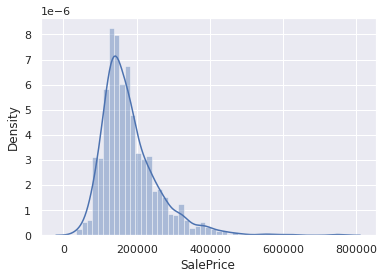

In [35]:
sns.distplot(data['SalePrice'])

Tenemos aqui una distribución con un gran pico, al igual que tenemos una cola grande a la derecha. Para ver que tanto nos alejamos de la distribución normal "normal", vamos a ver los siguientes valores. 

In [36]:
print("Skewness: ", data['SalePrice'].skew())
print("Kurtosis: ", data['SalePrice'].kurt())

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


Skewness es la falta de simetría en una distribución normal. Esto nos ayuda a ver si la distribución tiene la misma cantidad de datos a la izquierda de la media que a la derecha de la media. En este caso, como es positiva, tiene un skew hacia la derecha, lo que significa que hay mas datos a la derecha de nuestra media (algo que es cierto por que nuestra gráfica demuestra lo mismo)
Kurtosis nos ayuda a ver que tantas anomalías hay en nuestros datos. El valor predeterminado en una distribución normal es 3, por lo cual un 6 indica que será una gráfica con un pico alto (lo cual es cierto) 

## 2. Análisis de las variables que más influyen al precio de la casa

Ahora que ya entendemos nuestra variable más importante 'SalePrice', vamos a ver como se relacióna esta con todas las otras variables independientes utilizando un heatmap. 

<AxesSubplot:>

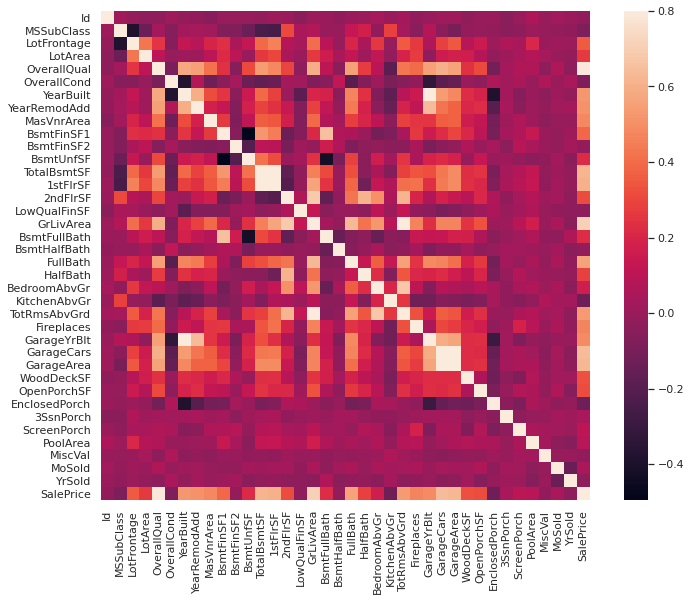

In [37]:
correlacion = data.corr()
f, ax = plt.subplots(figsize = (12,9))
sns.heatmap(correlacion, vmax = .8, square = True)

Como podemos observar en la fila de hasta abajo (SalePrice), esta variable tiene una gran correlación con OverallQual, GrLiveArea, GarageCars, 1stFlrSF y TotalBsmtSF. Ahora ya tenemos una mejor idea de a que aspectos podemos prestarle atención, hagamos un heatmap más detallado de este. 

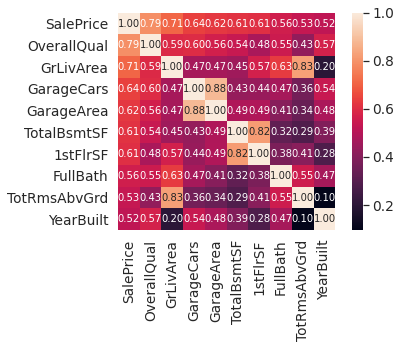

In [38]:
#Numero de variables a evaluar en el heatmap
n = 10
columnas = correlacion.nlargest(n, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[columnas].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columnas.values, xticklabels=columnas.values)
plt.show()

Ahora ya podemos sacar conclusiones concretas de las variables que más influyen al precio de venta de una casa:
1. La calidad de la vivienda, el área utilizable para la vivienda y la capacidad del garage son los componentes más influyentes en la compra de una casa. 
2. Los datos de GarageCars, Garage Area son codependientes, ya que hablan de lo mismo. Esto pasa también con TotalBsmtSF y 1stFlrSF, al igual que con GrLiveArea y TotRmsAbvGrd por lo cual podemos utilizar solo uno de cada uno para no ser redundantes en nuestro estudio. 
3. Es muy importante al parecer que una casa tenga baño completo (FullBath)...?
4. El año en que fue construida la casa también tiene importancia en el precio de venta.

### Graficas generales de variables

Ya que sabemos que variables se relacionan directamente con nuestro precio de venta, vamos a ver las relaciones entre cada una. 

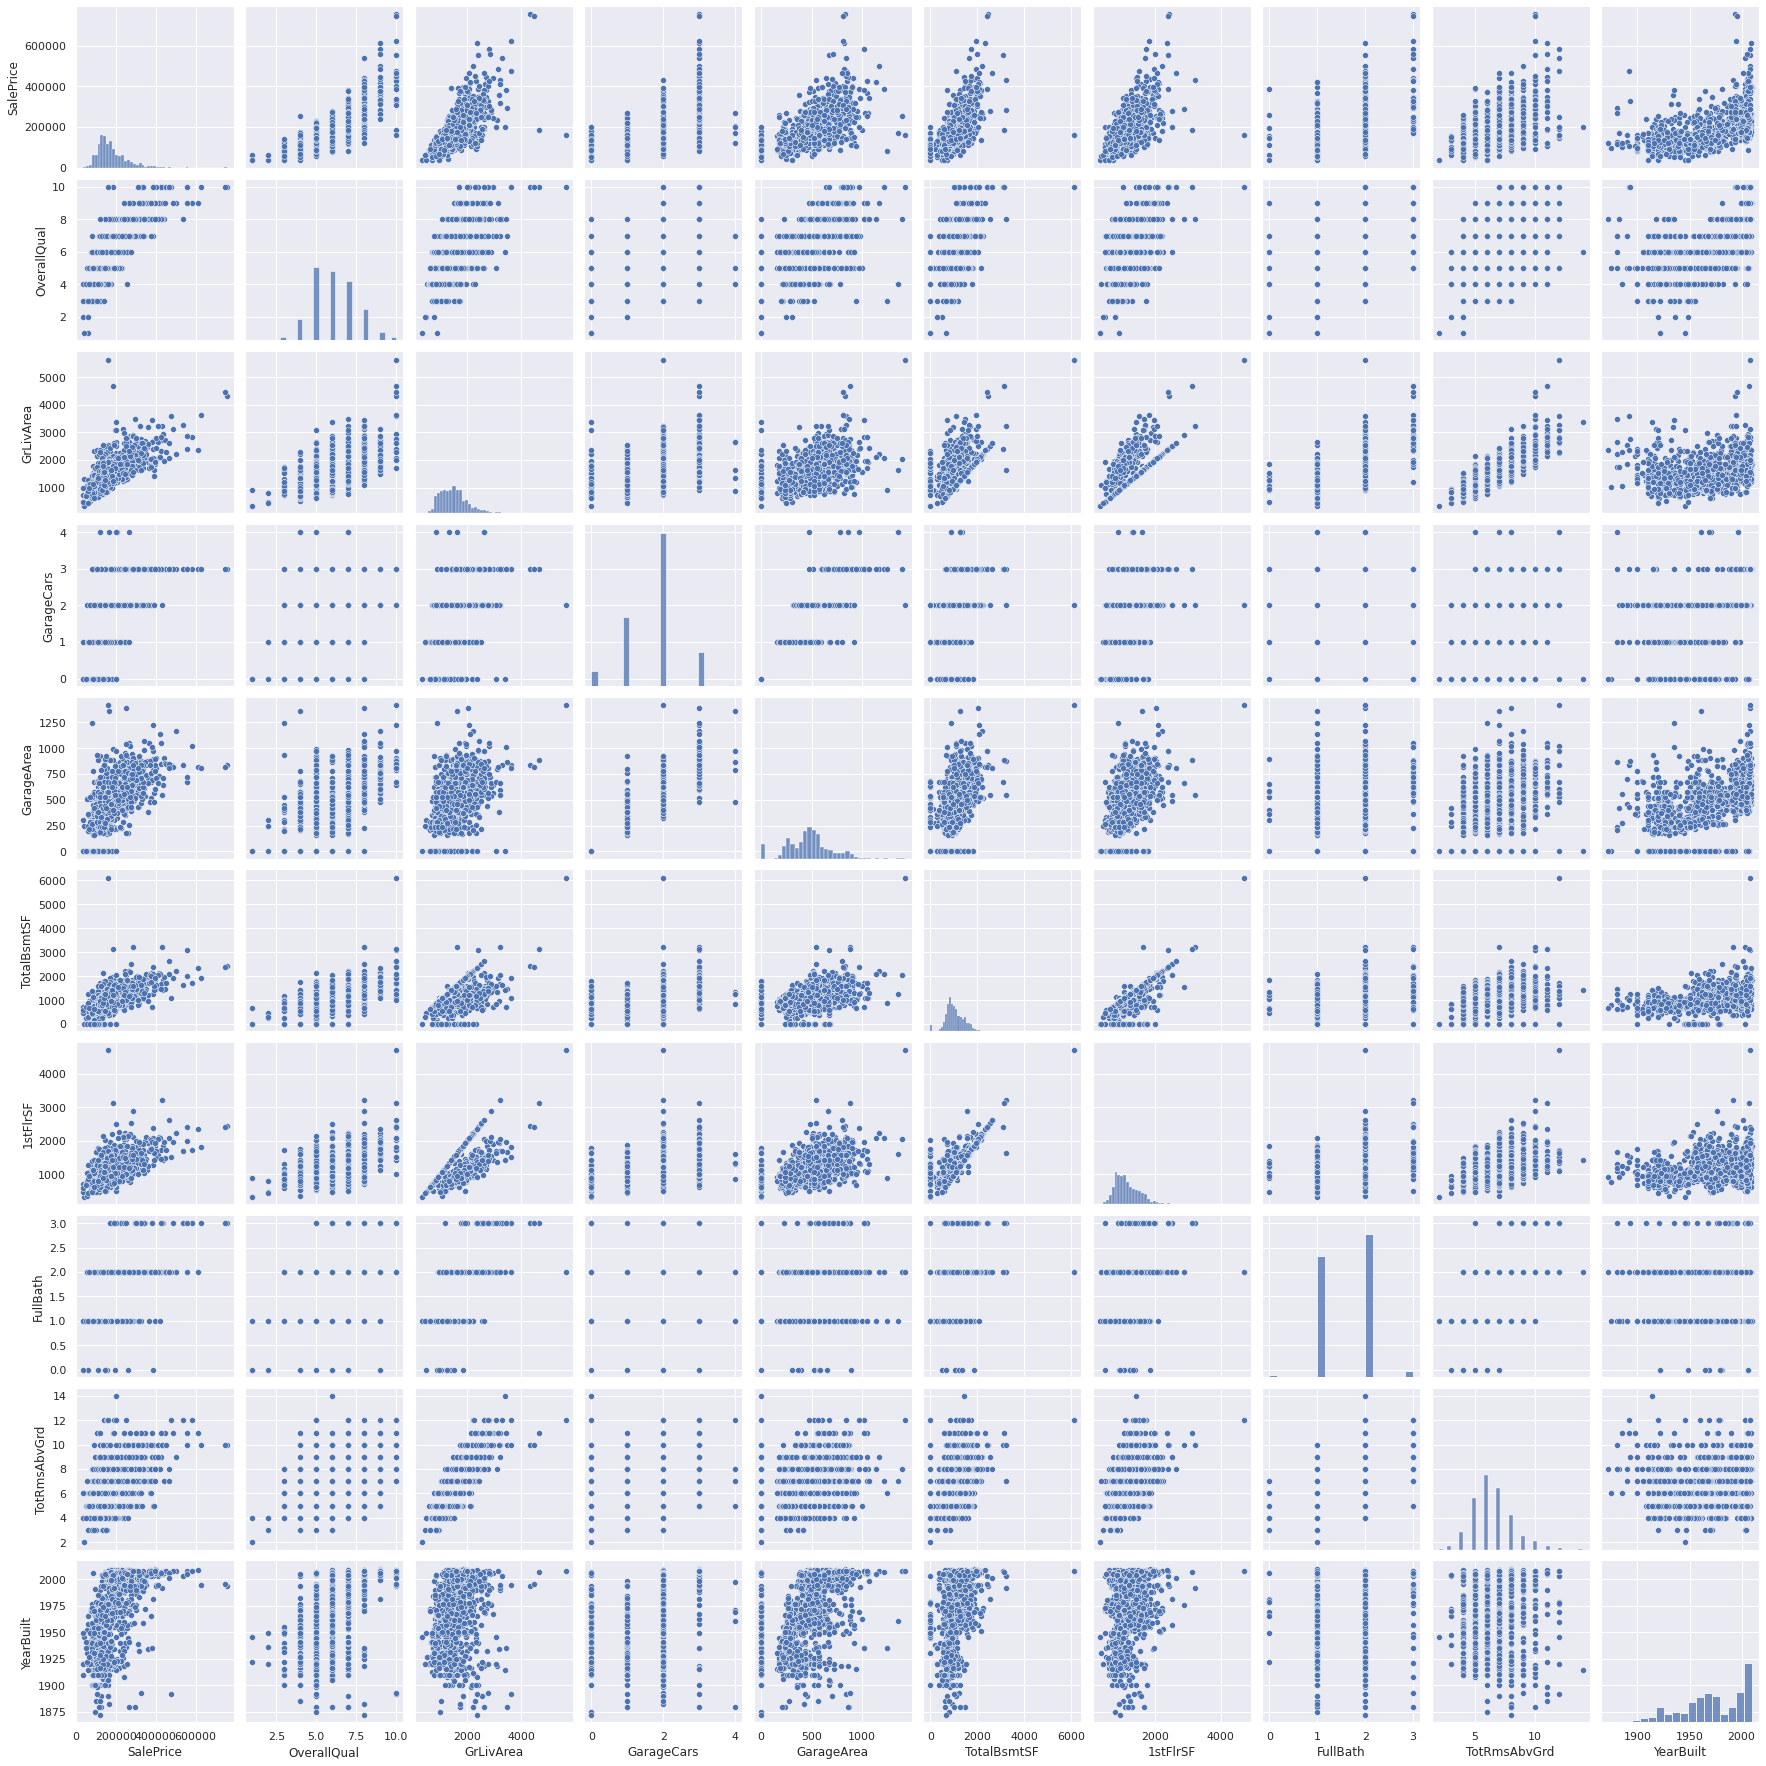

In [39]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data[columnas], size = 2.5)
plt.show();

Aqui podemos ver ciertas tendencias que nos pueden aportar más a darnos una idea de las variables independientes. 
* Todas las relaciones son correlaciones positivas y la mayoria son fuertes.
* Algo muy interesante es que el área del garage tiene una linea invisible donde no pasa. Si comparamos esto a la gráfica del área de la casa, hace sentido, ya que generalmente no vamos a comprar una casa que tenga más espacio en su garage que en el área donde vivimos. 
* En la variable de área de vivienda tenemos algunas anomalías que se salen de nuestras tendencias. Esto es importante observar ya que esta variable es de las más influyentes en el precio de venta. Procederemos a ver que pasa con esta en las siguientes secciones. 


### 3. Limpieza de datos 

Ahora que ya tenemos las variables que más influyen en el precio de la casa, vamos a ver que variables pueden afectarnos al momento de introducir los datos en modelos predictivos. Para eso, primero miremos que variables contienen valores nulos y por qué es esto (¿Nos está diciend algo que tengan valores nulos? O es solamente datos que no todas las casas contienen y no poseen información releavante)

In [40]:
total = data.isnull().sum().sort_values(ascending = False)
porcentajes = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
data_faltante = pd.concat([total,porcentajes],axis = 1, keys =['Total', 'Porcentaje'])
data_faltante.head(20)

,Total,Porcentaje
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


Como podemos observar en la data, la variable que mayores valores nulos tiene es la piscina. Esto hace sentido, ya que la mayoria de casas no tienen de estas. Luego, tenemos características de miscelaneos, lo cual no lo reportan tanto a la hora de evaluar una casa. Finalmente, todos los otros parámetros que podemos observar (Alley, Fence, Fireplace) son atributos que al igual que la piscina, no todas las casas tienen. Sin embargo, como vimos previamente, estas variables no tienen mayor influencia con el precio de venta, por lo cual podemos eliminar la variable como tal. 

Luego, todos los parámetros restantes (a excepción de Electrical) son relacionados con parámetros que ya discutimos previamente. Por ejemplo, la mayoría de variables faltantes son relacionadas al garage, solo que en términos más específicos, como lo es el tipo, condición, año de construcción, etc. Como ya tomamos en cuenta el aspecto relacionado a esta en otras variables que tienen mayor relevancia para el precio de venta, las eliminaremos también. Esto pasa con todas las demás, ya que tienen relación con las variables que analizamos previamente. 
Finalmente, Electrical es solamente una variable y preferimos mejor eliminar la entrada que no contiene esta variable, que toda la columna. 

### En resumen: 
* Una parte de los datos que faltaban era debido a que estas variables no se encuentran en todas las casas (piscinas, chimeneas, etc.) y procederemos a eliminarlas ya que no influyen en mayor manera al precio de venta. 
* La otra gran parte de los datos que faltaban era debido a que son variables relacionadas con otras variables que ya habiamos analizado y pueden ser redundantes (año de construcción de garage (obviamente construyeron el garage el año de construcción de la casa), tipo de garage (?) etc.) por lo cual procederemos a eliminarlas ya que ya las tomamos en cuenta indirecta y directamente con las variables que analizamos previamente. 
* Finalmente, la variable 'Electrical' decidimos conservarla ya que es solo una entrada la que no contiene esta variable, por lo cual mejor eliminaremos la entrada únicamente. 

In [41]:
## Eliminamos todos los datos faltantes en nuestro dataframe, excepto Electrical por que su cuenta no era mayor a 1
data = data.drop((data_faltante[data_faltante['Total']>1]).index, 1)

In [42]:
##Eliminamos el valor en Electrical donde la entrada era nula
data = data.drop(data.loc[data['Electrical'].isnull()].index)

In [43]:
##Comprobemos si ya no quedan valores nulos
data.isnull().sum().max()

0

### 4. Estandarización de los datos para ubicar tendencias

Bueno bueno, ahora ya mucho de limpieza y de las cosas aburridas, se viene lo chido. Si queremos empezar a crear modelos predictivos, necesitamos datos lo más estandarizados posibles para que no nos manipulen los resultados de nuestros modelos. Para eso primero tenemos que estandarizarla y ver si hay algunos datos que se comportan como anomalías (y que nos transmiten estos)

In [44]:
precio_estandarizado = StandardScaler().fit_transform(data['SalePrice'][:,np.newaxis]);
rango_bajo = precio_estandarizado[precio_estandarizado[:,0].argsort()][:10]
rango_alto = precio_estandarizado[precio_estandarizado[:,0].argsort()][-10:]

In [45]:
print('Rango bajo de estandarización', rango_bajo)
print('Rango alto de estandarización', rango_alto)

Rango bajo de estandarización [[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]
Rango alto de estandarización [[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


¿Qué es todo esto? Aunque se mire muy complejo, lo único que hice aqui fue crear un nuevo dataframe donde los precios bajos son similares a cero, mientras que los precios muy altos se separan mucho de cero, por lo cual podremos ver facilmente las anomalías. 

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

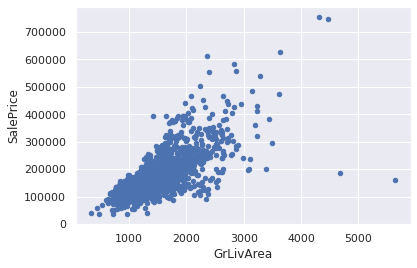

In [46]:

g1 = pd.concat([data['SalePrice'], data['GrLivArea']], axis=1)
g1.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

En la gráfica podemos observar que tenemos dos puntos yendo hacia la esquina inferior derecha. Esto nos dice que hay dos casas que tienen bastante área pero que cuestan poco. Podriamos ir a investigar un poco más acerca de por qué se da este fenómeno (se me ocurre que esta casa está situada en un lugar desolado) pero de igual manera estas no siguen la tendencia de los datos, por lo cual es mejor eliminar estas dos entradas. 

In [47]:
data.sort_values(by = 'GrLivArea', ascending = False)[:2]
data = data.drop(data[data['Id'] == 1299].index)
data = data.drop(data[data['Id'] == 524].index)

Ahora veamos la relación del SalePrice estandarizado con 'TotalBsmtSF'

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

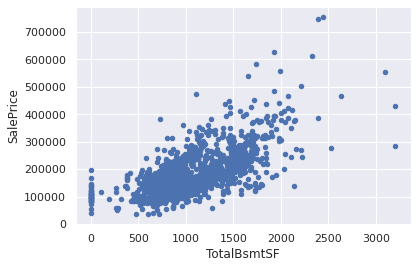

In [48]:
g2 = pd.concat([data['SalePrice'],data['TotalBsmtSF']], axis = 1)
g2.plot.scatter(x = 'TotalBsmtSF', y = 'SalePrice')

La gráfica nos demuestra algunos puntos que mahh, si se desvían de la agrupación principal, pero de igual manera siguen la tendencia de los otros datos. Por eso mismo, no hace falta hacer ninguna modificación a nuestro dataframe y ya podemos introducirlo a un modelo predictivo.

## Conclusiones

Este estudio nos permitió observar los distintos componentes que pueden influir en el precio de una casa en el mercado. Usualmente siempre pensamos que la localización es el factor que más afecta en el precio de la venta de una casa, pero ahora logramos observar que la mayor importancia es la calidad de la casa.
En resumen, logramos observar lo siguiente:
1. La variable de calidad de la casa ('OverallQual') es la más relevante en la venta de una casa. Por eso mismo, si va a vender una casa, es muy recomendable restaurar detalles para poder aumentar su precio de venta.
2. El segundo factor más relevante es el área de vivienda, ('GrLivArea'). Esta hace sentido, ya que siempre va a ser más costosa una casa con mayor área. 
3. Los factores relacionados a temas de garage y capacidad del mismo tienen influencia con el precio de venta
4. Finalmente, talvez el parámetro que más sorprende al momento de vender una casa, es que esta tenga un baño completo. Entonces, podemos decir que si quiere vender su casa en un buen precio, construyale un buen baño en lugar de una piscina. 


### Comentarios

Este es mi primer notebook realizado para análisis de datos de una competencia. Todo lo realizado aquí puede después ser incorporado en un modelo de Machine Learning para poder después poder predecir los precios de venta de casas en base a sus parámetros. Esta herramienta podría después ser desarrollada para empresas inmobiliarias, para poder vender casas a precios razonables y tener una idea antes de analizarla completamente del rango de precio donde se puede vender las propiedades. 